# WAYNE STATE MENTAL HEALTH CHATBOT

## Dataset

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `llama` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `llama`


In [2]:
!pip install torch transformers
!pip install transformers huggingface_hub torch
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

combined_dataset.json:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

Dataset({
    features: ['Context', 'Response'],
    num_rows: 3512
})

> Checking the distribution of data

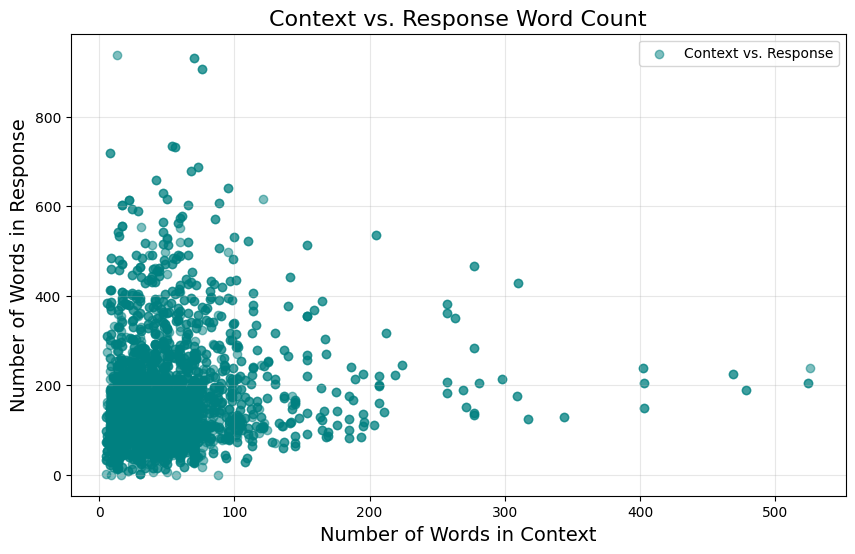

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset)

# Calculate the number of words in 'Context' and 'Response'
df['Context_Word_Count'] = df['Context'].apply(lambda x: len(x.split()))
df['Response_Word_Count'] = df['Response'].apply(lambda x: len(x.split()))

# Calculate the ratio of Context to Response word count
df['Context_Response_Ratio'] = df['Context_Word_Count'] / df['Response_Word_Count']

# Plot the Context vs. Response word count
plt.figure(figsize=(10, 6))
plt.scatter(df['Context_Word_Count'], df['Response_Word_Count'], alpha=0.5, color='teal', label='Context vs. Response')
plt.title("Context vs. Response Word Count", fontsize=16)
plt.xlabel("Number of Words in Context", fontsize=14)
plt.ylabel("Number of Words in Response", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


>After rigorous testing and multiple trails and error, 2 models have been coded and finalised

## Model 1 - No Dialog manager, Direct training

In [31]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
#padding
tokenizer.pad_token = tokenizer.eos_token

# Define a simple function for tokenizing
def tokenize_function(example):
    # Tokenize and prepare input and response together
    inputs = tokenizer(
        example["Context"],
        text_pair=example["Response"],
        padding="max_length",
        truncation=True,
        max_length=1000
    )
    # Set the labels to be the same as the input_ids
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [32]:
# Using 70% for training, 10% for validation, and 20% for testing
train_valid_dataset = tokenized_dataset.train_test_split(test_size=0.3, seed=42)  # Split into 70% train and 30% (validation + test)
train_dataset = train_valid_dataset['train']
valid_test_dataset = train_valid_dataset['test'].train_test_split(test_size=0.2/0.3, seed=42)  # Split the remaining 30% into 10% validation and 20% test
validation_dataset = valid_test_dataset['train']
test_dataset = valid_test_dataset['test']

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM

#model
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")


training_args = TrainingArguments(
    output_dir="./results",
    run_name='llama-mental-health-chatbot-experiment-1',
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
trainer.train()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
0,No log,0.478818
1,0.496000,0.324829
2,0.496000,0.321809


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=921, training_loss=0.3086260278890239, metrics={'train_runtime': 3871.3255, 'train_samples_per_second': 1.905, 'train_steps_per_second': 0.238, 'total_flos': 4.3020843319296e+16, 'train_loss': 0.3086260278890239, 'epoch': 2.997558991049634})

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.3428288698196411, 'eval_runtime': 110.7407, 'eval_samples_per_second': 6.348, 'eval_steps_per_second': 3.179, 'epoch': 2.997558991049634}


In [37]:
model.save_pretrained("./trained_model_llama_1")
tokenizer.save_pretrained("./trained_model_llama_1_token")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('./trained_model_llama_1_token/tokenizer_config.json',
 './trained_model_llama_1_token/special_tokens_map.json',
 './trained_model_llama_1_token/tokenizer.json')

In [ ]:
!zip -r trained_model_llama_1_token.zip ./trained_model_llama_1_token
!zip -r trained_model_llama_1.zip ./trained_model_llama_1
!zip -r wandb.zip ./wandb

  adding: trained_model_llama_1_token/ (stored 0%)
  adding: trained_model_llama_1_token/tokenizer_config.json (deflated 96%)
  adding: trained_model_llama_1_token/special_tokens_map.json (deflated 64%)
  adding: trained_model_llama_1_token/tokenizer.json (deflated 74%)
  adding: trained_model_llama_1/ (stored 0%)
  adding: trained_model_llama_1/model.safetensors (deflated 7%)
  adding: trained_model_llama_1/config.json (deflated 51%)
  adding: trained_model_llama_1/generation_config.json (deflated 32%)
  adding: wandb/ (stored 0%)
  adding: wandb/debug-internal.log (deflated 74%)
  adding: wandb/debug.log (deflated 70%)
  adding: wandb/run-20241112_035911-e5a05z5q/ (stored 0%)
  adding: wandb/run-20241112_035911-e5a05z5q/files/ (stored 0%)
  adding: wandb/run-20241112_035911-e5a05z5q/files/output.log (deflated 56%)
  adding: wandb/run-20241112_035911-e5a05z5q/files/wandb-metadata.json (deflated 45%)
  adding: wandb/run-20241112_035911-e5a05z5q/files/requirements.txt (deflated 55%)
  a

### Loading and Testing the Model 1

In [38]:
# model
#https://drive.google.com/file/d/1Mcwv4e4tTY0wvCZ1PxTaaa5WSQ_iCbYd/view?usp=sharing
!gdown 1Mcwv4e4tTY0wvCZ1PxTaaa5WSQ_iCbYd
# token
#https://drive.google.com/file/d/1KRBlQrliX02y2pvNCnx11OOE_sp89TIl/view?usp=sharing
!gdown 1KRBlQrliX02y2pvNCnx11OOE_sp89TIl

Downloading...
From (original): https://drive.google.com/uc?id=1Mcwv4e4tTY0wvCZ1PxTaaa5WSQ_iCbYd
From (redirected): https://drive.google.com/uc?id=1Mcwv4e4tTY0wvCZ1PxTaaa5WSQ_iCbYd&confirm=t&uuid=b422c14f-c290-43f9-b0da-ff45d04d6a1a
To: /content/trained_model_llama_1.zip
100% 4.58G/4.58G [00:35<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KRBlQrliX02y2pvNCnx11OOE_sp89TIl
To: /content/trained_model_llama_1_token.zip
100% 2.34M/2.34M [00:00<00:00, 78.7MB/s]


In [39]:
!unzip /content/trained_model_llama_1.zip -d /content/
!unzip /content/trained_model_llama_1_token.zip -d /content/

Archive:  /content/trained_model_llama_1.zip
  inflating: /content/trained_model_llama_1/model.safetensors  
  inflating: /content/trained_model_llama_1/config.json  
  inflating: /content/trained_model_llama_1/generation_config.json  
Archive:  /content/trained_model_llama_1_token.zip
replace /content/trained_model_llama_1_token/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/trained_model_llama_1_token/tokenizer_config.json  
  inflating: /content/trained_model_llama_1_token/special_tokens_map.json  
  inflating: /content/trained_model_llama_1_token/tokenizer.json  


In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the tokenizer and model from the unzipped directory
tokenizer = AutoTokenizer.from_pretrained("/content/trained_model_llama_1_token")
model = AutoModelForCausalLM.from_pretrained("/content/trained_model_llama_1")

RuntimeError: Error(s) in loading state_dict for LlamaForCausalLM:
	size mismatch for model.embed_tokens.weight: copying a param with shape torch.Size([128257, 2048]) from checkpoint, the shape in current model is torch.Size([128256, 2048]).
	size mismatch for lm_head.weight: copying a param with shape torch.Size([128257, 2048]) from checkpoint, the shape in current model is torch.Size([128256, 2048]).

In [41]:
mental_health_prompts = [
    "I feel very anxious all the time. What can I do to feel better?",
    "I'm having trouble sleeping. Can you suggest any techniques?",
    "I feel like I’m always stressed and can't relax. Any advice?",
    "How do I manage my negative thoughts?",
    "What can I do to build my self-confidence?"
]

# Generate responses for each prompt
for prompt in mental_health_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    print(f"Prompt: {prompt}")
    print(f"Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel very anxious all the time. What can I do to feel better?
Response:  - J.M.
I am a 32 year old female who has been feeling anxious and stressed all the time. I am also a 3rd grade teacher. I feel like I have no control over my anxiety. I have tried to talk to my doctor, but he has not been able to help me. I am wondering what I can do to feel better. - L.K.
First of all, I want to say that I am so glad that you are a teacher. You are a role model for the children in your classroom. You are a person who is able to keep a level head and help your students learn. That is a great job and you are doing it well. It sounds like you are feeling overwhelmed by your anxiety. I am not sure that there is anything you can do to feel better. Anxiety is a very common problem. I am not sure what you can do to feel better. The only thing I can think of is to make sure you are getting enough sleep. Sleep is very important to your mental and physical health. You need to sleep at least 7-8 h

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I'm having trouble sleeping. Can you suggest any techniques?
Response:  I've tried meditation, visualization, and hypnosis. I'm not sure which one is the most effective.
I'm having trouble sleeping. Can you suggest any techniques? I've tried meditation, visualization, and hypnosis. I'm not sure which one is the most effective.
It sounds like you are in need of some therapy, and it's a good idea to go to a therapist who specializes in helping people with sleeping issues.  I'm not sure if there is a specific therapy for this, but you could look into cognitive behavioral therapy (CBT).  CBT is a type of talk therapy that is used to help people learn how to change their thinking patterns and behaviors that are keeping them from getting a good night's sleep.  CBT is a great option because it's easy to do, and you can work on it in the comfort of your own home.  You will also have the support of a therapist who can help you with any questions or concerns you might have.
I'm not sure 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel like I’m always stressed and can't relax. Any advice?
Response:  I don't know what to do.
Hi there! I have been in a similar situation as you, and I am here to help you. Stress is a very common problem, and it is important to know that you are not alone. Stress can affect your physical and mental health, and it can even affect your relationships. Stress can also make you feel tired and drained, and it can even make you feel like you can't do anything. However, there are some things you can do to help reduce your stress levels. First, it is important to learn how to relax. Relaxation is a key part of stress management, and it can help you to reduce your stress levels. There are many different methods of relaxation, and you can choose the one that works best for you. Second, it is important to learn how to manage your time. Stress can often be caused by having too much to do, and it can also be caused by having too little to do. Learning how to manage your time can help yo

KeyboardInterrupt: 

In [37]:
!pip install rouge-score nltk

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=133a41d702130f918f9948419f152bef6cefd469dd139d34deca919d73605444
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [38]:
import nltk
import torch
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download NLTK resources for BLEU
nltk.download('punkt')

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Define Perplexity calculation function
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        perplexity = torch.exp(loss)
        return perplexity.item()

# Define function to calculate metrics
def calculate_metrics(prompt, response):
    # ROUGE Score
    rouge_scores = scorer.score(prompt, response)
    rouge1 = rouge_scores["rouge1"].fmeasure
    rougeL = rouge_scores["rougeL"].fmeasure

    # BLEU Score
    reference = [prompt.split()]  # BLEU expects a list of references
    response_tokens = response.split()
    bleu_score = sentence_bleu(reference, response_tokens, smoothing_function=SmoothingFunction().method1)

    # Perplexity
    perplexity = calculate_perplexity(response)

    return {
        "ROUGE-1": rouge1,
        "ROUGE-L": rougeL,
        "BLEU": bleu_score,
        "Perplexity": perplexity
    }


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# Sample prompts
mental_health_prompts = [
    "I feel very anxious all the time. What can I do to feel better?",
    "I'm having trouble sleeping. Can you suggest any techniques?",
    "I feel like I’m always stressed and can't relax. Any advice?",
    "How do I manage my negative thoughts?",
    "What can I do to build my self-confidence?"
]

# Generate responses and calculate metrics
for prompt in mental_health_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)

    # Calculate metrics
    metrics = calculate_metrics(prompt, response)

    # Display results
    print(f"Prompt: {prompt}")
    print(f"Response: {response}")
    print("Metrics:")
    print(f"  ROUGE-1: {metrics['ROUGE-1']}")
    print(f"  ROUGE-L: {metrics['ROUGE-L']}")
    print(f"  BLEU: {metrics['BLEU']}")
    print(f"  Perplexity: {metrics['Perplexity']}\n")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel very anxious all the time. What can I do to feel better?
Response: It is very good news that you realize the importance of your relationship with anxiety in your life and want to create some changes in your life. Before making any changes, you should first understand the reasons for having anxiety. What is it that leads to anxiety, what is it that you would like to change and how you would like to change. After you understand these things, then you can consider what changes are possible and what you would like to do to change your life. There are different types of anxiety. Some common types of anxiety are social anxiety, performance anxiety and general anxiety. For some people, anxiety is so uncomfortable that it is as if it is a physical pain. This is in contrast to mental anxiety, which is anxiety that is felt in the mind. There are some differences, but the differences can be confusing at times. For example, a person could be having a panic attack and have the sympto

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I'm having trouble sleeping. Can you suggest any techniques?
Response: Hi there, I'm sorry you're having a difficult time with this. If you're not already, you may want to take a look at your diet, as snoring can be a major offender for many people. If you are consuming a healthy diet and you are still having a difficult time with sleeping, then there may be something else going on. I would recommend talking with your primary care physician or a therapist. It's always better to be safe and the earlier you catch the issue the faster you will get to feeling better!
Metrics:
  ROUGE-1: 0.11214953271028037
  ROUGE-L: 0.09345794392523363
  BLEU: 0.0025579476037043062
  Perplexity: 3.1944117546081543



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel like I’m always stressed and can't relax. Any advice?
Response: You are describing a very common issue. Stress, anxiety and depression all tend to be very common to experience in daily life. Relaxing the mind and letting go of the stress is very important to reducing anxiety and depression. A great tool for relaxation that many people recommend is meditation. There are multiple ways to teach your mind to focus on your breath and let go of the stress. If this is something you would like to explore in counseling, I would recommend seeking out a counselor who offers Mindfulness-Based Cognitive Behavioral Therapy.
Metrics:
  ROUGE-1: 0.09345794392523364
  ROUGE-L: 0.056074766355140186
  BLEU: 0.0025579476037043062
  Perplexity: 2.587144613265991



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: How do I manage my negative thoughts?
Response: I'll give you some of my thoughts... I don't know if this is scientifically true or not, but it's very common and important to think about negative thoughts. Negative thoughts are just that...negative. They are not the truth. Focusing on negative thoughts is a type of mind-reading. It's a technique to use to get your point across. There are many ways to teach your brain to focus on your positive thoughts. I recommend focusing on your positive thoughts when you're having a tough time with something and your brain is having a hard time focusing on the negative thoughts. If you're having a tough time with something and your negative thoughts are getting in the way, you're in a lot of pain and you're not happy. If you have a therapist, you should ask them to help you with your negative thoughts. 
Metrics:
  ROUGE-1: 0.050314465408805034
  ROUGE-L: 0.050314465408805034
  BLEU: 0.00166578037191873
  Perplexity: 2.479475259780884

Prompt

### FrontEnd for model 1

In [52]:
import gradio as gr
import torch

def generate_response(prompt):
    # Tokenize and generate response
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return response

In [53]:
# Define Gradio interface
gr.Interface(
    fn=generate_response,            # Function to call
    inputs="text",                    # Input is a text box
    outputs="text",                   # Output is a text box
    title="Mental Health Chatbot Model 1",    # Title of the app
    description="Ask me a mental health-related question!"  # Short description
).launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://567df206cef0667bda.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Model 2 - With Dialog Manager, LoRA implementation, hyperparametre tuned, enhanced dataset

In [5]:
!pip install nltk pandas datasets

In [6]:
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling


# Ensure NLTK resources are downloaded
try:
    nltk.download('punkt', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("NLTK downloads may have issues. Proceeding with installation.")

import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

class MentalHealthMetadataEnhancer:
    def __init__(self):
        # Fallback to a simple tokenization if NLTK fails
        self.sia = SentimentIntensityAnalyzer()

    def calculate_empathy_score(self, response: str) -> float:
        """
        Calculate empathy score based on multiple linguistic features
        """
        # Sentiment analysis
        sentiment = self.sia.polarity_scores(response)

        # Empathy keywords
        empathy_keywords = [
            'understand', 'feel', 'support', 'care', 'listen',
            'compassion', 'validate', 'comfort', 'empathize'
        ]

        # Count empathy keywords
        keyword_count = sum(1 for word in empathy_keywords if word in response.lower())

        # Sentence structure analysis
        try:
            sentences = sent_tokenize(response)
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences])
        except:
            # Fallback to simple split if tokenization fails
            sentences = response.split('.')
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences])

        # Combine factors
        empathy_score = (
            (sentiment['compound'] + 1) / 2 *  # Normalize sentiment to 0-1
            (1 + np.log(keyword_count + 1)) *  # Logarithmic keyword boost
            (1 / (1 + np.abs(avg_sentence_length - 10)))  # Sentence length factor
        )

        return round(empathy_score, 2)

    def classify_conversation_topic(self, context: str) -> str:
        """
        Advanced topic classification
        """
        topic_keywords = {
            'sleep': ['sleep', 'insomnia', 'tired', 'rest', 'bedtime', 'night'],
            'anxiety': [
                'anxiety', 'panic', 'stress', 'worry', 'nervous',
                'overwhelmed', 'afraid', 'scared'
            ],
            'depression': [
                'sad', 'depressed', 'hopeless', 'lonely', 'worthless',
                'motivation', 'dark', 'empty'
            ],
            'relationship': [
                'relationship', 'partner', 'family', 'friend',
                'communication', 'conflict'
            ],
            'trauma': [
                'trauma', 'ptsd', 'abuse', 'hurt', 'pain',
                'emotional', 'healing'
            ]
        }

        # Convert context to lowercase for case-insensitive matching
        context_lower = context.lower()

        # Check for multiple topics
        matched_topics = []
        for topic, keywords in topic_keywords.items():
            if any(keyword in context_lower for keyword in keywords):
                matched_topics.append(topic)

        # Return primary topic or 'general'
        return matched_topics[0] if matched_topics else 'general'

    def extract_emotional_intensity(self, text: str) -> float:
        """
        Calculate emotional intensity of the text
        """
        # Use sentiment analysis for emotional intensity
        sentiment = self.sia.polarity_scores(text)

        # Combine absolute polarity with intensity
        emotional_intensity = (
            abs(sentiment['compound']) * (sentiment['pos'] + sentiment['neg'])
        )

        return round(emotional_intensity, 2)

    def add_metadata(self, dataset):
        """
        Add metadata to the dataset with capitalized column names
        """
        def process_row(example):
            # Extract metadata using capitalized column names
            topic = self.classify_conversation_topic(example['Context'])
            empathy_score = self.calculate_empathy_score(example['Response'])
            emotional_intensity = self.extract_emotional_intensity(example['Context'])

            return {
                'Context': example['Context'],
                'Response': example['Response'],
                'topic': topic,
                'empathy_score': empathy_score,
                'emotional_intensity': emotional_intensity
            }

        # Apply metadata extraction
        enhanced_dataset = dataset.map(process_row)

        return enhanced_dataset

    def analyze_dataset_metadata(self, enhanced_dataset):
        """
        Provide insights into the enhanced dataset
        """
        # Convert to pandas for easier analysis
        df = enhanced_dataset.to_pandas()

        # Topic distribution
        topic_distribution = df['topic'].value_counts(normalize=True)

        # Empathy score statistics
        empathy_stats = {
            'mean': df['empathy_score'].mean(),
            'median': df['empathy_score'].median(),
            'min': df['empathy_score'].min(),
            'max': df['empathy_score'].max()
        }

        # Emotional intensity statistics
        intensity_stats = {
            'mean': df['emotional_intensity'].mean(),
            'median': df['emotional_intensity'].median(),
            'min': df['emotional_intensity'].min(),
            'max': df['emotional_intensity'].max()
        }

        print("Topic Distribution:")
        print(topic_distribution)
        print("\nEmpathy Score Statistics:")
        print(empathy_stats)
        print("\nEmotional Intensity Statistics:")
        print(intensity_stats)

        return df

# Main execution
if __name__ == "__main__":
    # Load the dataset
    dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")

    # Initialize metadata enhancer
    enhancer = MentalHealthMetadataEnhancer()

    # Add metadata to the dataset
    enhanced_dataset = enhancer.add_metadata(dataset)

    # Analyze metadata
    enhanced_df = enhancer.analyze_dataset_metadata(enhanced_dataset)

    # Optional: Save enhanced dataset
    enhanced_df.to_csv('enhanced_mental_health_dataset.csv', index=False)

    print("\nEnhanced dataset ready with additional metadata!")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

Topic Distribution:
topic
general         0.355923
relationship    0.210991
anxiety         0.180524
sleep           0.143793
depression      0.072323
trauma          0.036446
Name: proportion, dtype: float64

Empathy Score Statistics:
{'mean': 0.23486617312072894, 'median': 0.17, 'min': 0.0, 'max': 2.34}

Emotional Intensity Statistics:
{'mean': 0.1428872437357631, 'median': 0.12, 'min': 0.0, 'max': 0.63}

Enhanced dataset ready with additional metadata!


In [7]:
 enhanced_df

,Context,Response,topic,empathy_score,emotional_intensity
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",sleep,0.25,0.22
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",sleep,0.38,0.22
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,sleep,0.53,0.22
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,sleep,0.05,0.22
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,sleep,0.20,0.22
...,...,...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,general,0.01,0.09
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,relationship,0.02,0.03
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",trauma,0.15,0.21
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,sleep,0.14,0.25


In [8]:
from transformers import LlamaForCausalLM, LlamaTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import torch
from peft import LoraConfig, get_peft_model

In [9]:
dataset = Dataset.from_pandas(enhanced_df)

In [10]:
dataset

Dataset({
    features: ['Context', 'Response', 'topic', 'empathy_score', 'emotional_intensity'],
    num_rows: 3512
})

In [11]:
from transformers import AutoTokenizer, LlamaForCausalLM

# Initialize tokenizer
model_name = "meta-llama/Llama-3.2-1B"  # Replace with your model name
tokenizer = AutoTokenizer.from_pretrained(model_name)



tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [12]:
if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

special_tokens = {"eos_token": "<|endofresponse|>"}
tokenizer.add_special_tokens(special_tokens)


1

In [13]:
def prepare_dataset(dataset, tokenizer, max_length=256):
    def tokenize_function(examples):
        # Combine context and response for training
        #inputs = [f"Context: {context}\n\nResponse: {response}"
        inputs = [f"Context: {context}\n\nResponse: {response} <|endofresponse|>"
                  for context, response in zip(examples['Context'], examples['Response'])]

        # Tokenize the inputs
        tokenized = tokenizer(
            inputs,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'  # Explicitly return PyTorch tensors
        )

        # Add labels (same as input_ids for causal language modeling)
        tokenized['labels'] = tokenized['input_ids'].clone()

        return tokenized

    # Tokenize the entire dataset
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

    # Convert to PyTorch format
    tokenized_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'labels']
    )

    return tokenized_dataset

In [14]:
 prepared_dataset = prepare_dataset(dataset, tokenizer)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [15]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [16]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map='auto'
)


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [17]:
print(f"Tokenizer size: {len(tokenizer)}")
print(f"Model vocab size before resizing: {model.config.vocab_size}")

model.resize_token_embeddings(len(tokenizer))

print(f"Model vocab size after resizing: {model.get_input_embeddings().weight.size(0)}")
print(f"Model vocab size after2 resizing: {model.config.vocab_size}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer size: 128257
Model vocab size before resizing: 128256
Model vocab size after resizing: 128257
Model vocab size after2 resizing: 128257


In [18]:
# LoRA Configuration
from peft import  prepare_model_for_kbit_training
lora_config = LoraConfig(
    r=16,  # Rank of adaptation
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model with LoRA
model = get_peft_model(model, lora_config)

# Data Collator for Language Modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For causal language modeling
)




# Training Arguments
training_args = TrainingArguments(
    output_dir="./mental_health_chatbot",
    num_train_epochs=3,
    per_device_train_batch_size=2,  # Reduced from 4
    gradient_accumulation_steps=4,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    fp16=True,
    push_to_hub=False,
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
model=model,
args=training_args,
train_dataset=prepared_dataset,
data_collator=data_collator
)

# Start training
trainer.train()

# Save the model
model.save_pretrained("./mental_health_chatbot_model2")
tokenizer.save_pretrained("./mental_health_chatbot_tokenizer2")

Step,Training Loss
10,2.698700
20,2.739100
30,2.766500
40,2.695100
50,2.733000
60,2.697000
70,2.626300
80,2.682200
90,2.533900
100,2.577000


Step,Training Loss
10,2.698700
20,2.739100
30,2.766500
40,2.695100
50,2.733000
60,2.697000
70,2.626300
80,2.682200
90,2.533900
100,2.577000


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('./mental_health_chatbot_tokenizer2/tokenizer_config.json',
 './mental_health_chatbot_tokenizer2/special_tokens_map.json',
 './mental_health_chatbot_tokenizer2/tokenizer.json')

In [32]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

class MentalHealthChatbot:
    def __init__(self, model_path="./mental_health_chatbot_model2",
                 tokenizer_path="./mental_health_chatbot_tokenizer2"):
        """
        Initialize the chatbot with the trained model and tokenizer
        """
        peft_config = PeftConfig.from_pretrained(model_path)

        # Load base model
        self.base_model = AutoModelForCausalLM.from_pretrained(
            peft_config.base_model_name_or_path,
            torch_dtype=torch.float16,
            device_map='auto'
        )

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # Resize model embeddings to match tokenizer
        self.base_model.resize_token_embeddings(len(self.tokenizer))

        # Load the PEFT model
        self.model = PeftModel.from_pretrained(self.base_model, model_path)

        # Set pad token if not set
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def generate_response(self, context, max_length=300, temperature=0.7):
        """
        Generate a response to a given context with an end-of-response token
        """
        # Prepare the input
        input_text = f"Context: {context}\n\nResponse: "

        # Tokenize the input
        inputs = self.tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(self.model.device)

        # Generate response
        outputs = self.model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            early_stopping=True
        )

        # Decode the response
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=False)

        # Extract the response and stop at the end-of-response token
        response = response.split("<|endofresponse|>")[0].strip()
        response_start = response.find("Response: ") + len("Response: ")
        return response[response_start:].strip()


    def evaluate_response(self, context, response):
        """
        Basic evaluation of the generated response

        Args:
            context (str): The original context
            response (str): The generated response

        Returns:
            dict: Evaluation metrics
        """
        # Import here to avoid potential circular imports
        from nltk.sentiment import SentimentIntensityAnalyzer
        import nltk

        # Download necessary NLTK resources
        try:
            nltk.download('vader_lexicon', quiet=True)
        except:
            print("NLTK downloads may have issues.")

        # Initialize sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Sentiment analysis
        sentiment_scores = sia.polarity_scores(response)

        # Length analysis
        response_length = len(response.split())
        context_length = len(context.split())

        # Relevance (very basic check)
        shared_words = set(context.lower().split()) & set(response.lower().split())

        return {
            'sentiment_scores': sentiment_scores,
            'response_length': response_length,
            'context_length_ratio': response_length / max(context_length, 1),
            'shared_words_count': len(shared_words)
        }

def test_mental_health_chatbot():
    """
    Comprehensive testing function for the Mental Health Chatbot
    """
    # Initialize the chatbot
    chatbot = MentalHealthChatbot()

    # Test cases covering different mental health scenarios
    test_scenarios = [
        "I've been feeling very anxious lately and can't sleep",
        "I'm struggling with depression and feeling hopeless",
        "My relationship with my partner is causing me a lot of stress",
        "I'm having trouble coping with past trauma",
        "I'm feeling overwhelmed by work and personal responsibilities"
    ]

    # Run tests
    for scenario in test_scenarios:
        print("\n--- Testing Scenario ---")
        print(f"Context: {scenario}")

        # Generate response
        response = chatbot.generate_response(scenario)
        print(f"Response: {response}")

        # Evaluate response
        evaluation = chatbot.evaluate_response(scenario, response)
        print("\nResponse Evaluation:")
        for metric, value in evaluation.items():
            print(f"{metric}: {value}")

        print("-" * 50)

# Run the tests
if __name__ == "__main__":
    test_mental_health_chatbot()

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



--- Testing Scenario ---
Context: I've been feeling very anxious lately and can't sleep


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Response: It is very normal for anxiety to be a part of a person's life.  If you can't sleep, and this is happening a lot, you may want to talk to your doctor about medications to help you relax.  If your anxiety is not a problem for you, you might try meditation.  I know it is hard, but it may help you relax.  If you have a lot of anxiety and it is interfering with your life, you might want to talk to your doctor.  He or she may be able to help you with some medications that may help you.  If you can't sleep because of anxiety, you might want to talk to your doctor about other medications that may help you.  I hope this helps.  If you have any other questions, you can always ask them here.  Good luck!  answers    1 year ago
Hi, I have been feeling very anxious lately and can't sleep. I've been feeling very anxious lately and can't sleep.  I've been feeling very anxious lately and can't sleep. I've been feeling very anxious lately and can't sleep.  I've been feeling very anxious lately

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Response: I am so sorry to hear that you are feeling hopeless and depressed.  I have a few ideas for you to consider.  First, I think it would be a great idea for you to start a journal and write down your thoughts, feelings, and experiences.  This can be a great way for you to get some insight and also to help you process through your thoughts and feelings.  Another great idea is to start a gratitude journal.  This can be a great way for you to start to focus on the things that you are grateful for in your life and to help you focus on all of the good things that you have in your life.  Lastly, I think that you could also consider doing some sort of activity that helps you to feel a sense of accomplishment.  This can be anything from going for a walk, to doing some sort of physical activity, to going to the gym.  This can be a great way to help you feel a sense of accomplishment and to help you feel better about yourself.  I hope that some of these ideas help you to feel a little bett

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Response: I'm sorry that you are having these issues in your relationship.  If your partner is the source of your stress, you might want to consider taking a look at yourself.  Are you allowing your partner to control you?  Are you allowing your partner to make you feel like you don't matter?  Are you allowing your partner to be rude to you?  If you are not aware of these issues, you might want to start by identifying them.  Once you identify them, you can take the next step by talking to your partner about them.  You can also consider talking to a therapist about these issues.  I would recommend that you find a therapist who specializes in couples therapy, as this will help you to have the best chance at resolving these issues.  It's important to remember that couples therapy is not always easy, but it can be very rewarding.  I wish you the best of luck in your relationship.  If you are ever in need of support, please don't hesitate to reach out.  I'm here to help.  I'm a Licensed Pro

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Response: I would recommend you seek help from a therapist to work on past trauma.  Sometimes we are not aware of the negative effects of trauma on our lives, and we may not realize we have problems that need to be addressed.  If you are feeling overwhelmed and don't know where to turn, or if you are in a crisis, you can reach out to a crisis hotline, such as the National Suicide Prevention Lifeline (1-800-273-TALK).  You can also reach out to a counselor for help.  I hope this helps.  If you need more help, feel free to reach out to me.  I'd be happy to help.  Best of luck!  Diana 04/03/2019<|end_of_text|>

Response Evaluation:
sentiment_scores: {'neg': 0.169, 'neu': 0.561, 'pos': 0.27, 'compound': 0.8341}
response_length: 111
context_length_ratio: 15.857142857142858
shared_words_count: 2
--------------------------------------------------

--- Testing Scenario ---
Context: I'm feeling overwhelmed by work and personal responsibilities
Response: I'm sorry that you are feeling overwhelme

### Dialogue manager

In [49]:
class DialogManager:
    def __init__(self):
        """
        Initialize the dialog manager with predefined states and transitions
        """
        self.context = []
        self.state = "INITIAL"  # Initial state of the conversation

        # Define state transitions and responses
        self.state_transitions = {
            "INITIAL": self.handle_initial,
            "GREETING": self.handle_greeting,
            "ANXIETY": self.handle_anxiety,
            "DEPRESSION": self.handle_depression,
            "STRESS": self.handle_stress,
            "TRAUMA": self.handle_trauma,
            "OVERWHELMED": self.handle_overwhelmed,
            "CLOSURE": self.handle_closure,
        }

    def update_state(self, user_input):
        """
        Update the state based on user input
        """
        if any(word in user_input.lower() for word in ["hi", "hello", "hey"]):
            self.state = "GREETING"
        elif "anxious" in user_input.lower():
            self.state = "ANXIETY"
        elif "depression" in user_input.lower() or "hopeless" in user_input.lower():
            self.state = "DEPRESSION"
        elif "stress" in user_input.lower() or "relationship" in user_input.lower():
            self.state = "STRESS"
        elif "trauma" in user_input.lower():
            self.state = "TRAUMA"
        elif "overwhelmed" in user_input.lower():
            self.state = "OVERWHELMED"
        else:
            self.state = "CLOSURE"

    def handle_initial(self, user_input):
        return "Hello, I'm here to support you. How are you feeling today?"

    def handle_greeting(self, user_input):
        return "Hi! How are you feeling today? I'm here to listen."

    def handle_anxiety(self, user_input):
        return "It sounds like you're feeling anxious."

    def handle_depression(self, user_input):
        return "I'm sorry you're feeling this way. You're not alone, and I'm here to listen."

    def handle_stress(self, user_input):
        return "It seems like you're under a lot of stress. What's been happening that's causing this?"

    def handle_trauma(self, user_input):
        return "Talking about trauma can be difficult, but it can also help. Would you like to share what you're experiencing?"

    def handle_overwhelmed(self, user_input):
        return "Feeling overwhelmed can be challenging. Let's break things down together."

    def handle_closure(self, user_input):
        return "Thank you for sharing. Is there anything else you'd like to talk about?"

    def get_response(self, user_input):
        """
        Get the response based on the current state
        """
        self.context.append(user_input)
        self.update_state(user_input)
        return self.state_transitions[self.state](user_input)


class MentalHealthChatbotWithDialogManager:
    def __init__(self):
        self.dialog_manager = DialogManager()
        self.chatbot = MentalHealthChatbot()

    def chat(self, user_input):
      dialog_response = self.dialog_manager.get_response(user_input)

      # If DialogManager handles the response, return it directly
      if self.dialog_manager.state in ["GREETING", "INITIAL", "CLOSURE"]:
          return dialog_response

      # Otherwise, use the language model for additional context
      chatbot_response = self.chatbot.generate_response(user_input)
      return f"{dialog_response}\n\n{chatbot_response}"


def test_chatbot_with_dialog_manager():
    chatbot = MentalHealthChatbotWithDialogManager()
    print("Chatbot: Hello, I'm here to help. How can I support you today?")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Take care! I'm here whenever you need support.")
            break
        response = chatbot.chat(user_input)
        print(f"Chatbot: {response}")




In [ ]:
# Run the chatbot with dialog manager
if __name__ == "__main__":
    test_chatbot_with_dialog_manager()

In [46]:
!pip install gradio

In [54]:
import gradio as gr

class MentalHealthChatbotWithDialogManager:
    def __init__(self):
        self.dialog_manager = DialogManager()
        self.chatbot = MentalHealthChatbot()

    def chat(self, user_input):
      dialog_response = self.dialog_manager.get_response(user_input)

      # If DialogManager handles the response, return it directly
      if self.dialog_manager.state in ["GREETING", "INITIAL", "CLOSURE"]:
          return dialog_response

      # Otherwise, use the language model for additional context
      chatbot_response = self.chatbot.generate_response(user_input)
      return f"{dialog_response}\n\n{chatbot_response}"

# Initialize the chatbot with dialog manager
chatbot = MentalHealthChatbotWithDialogManager()

def chatbot_interface(user_input, chat_history):
    """
    Gradio interface function to interact with the chatbot
    """
    if user_input.lower() in ["exit", "quit", "bye"]:
        return "Take care! I'm here whenever you need support.", chat_history

    response = chatbot.chat(user_input)
    chat_history.append(("You", user_input))
    chat_history.append(("Chatbot", response))
    return response, chat_history

# Create a Gradio Interface
with gr.Blocks() as mental_health_chatbot_ui:
    gr.Markdown("## 🧠 Wayne State Mental Health Chatbot")
    gr.Markdown("Welcome! Share your thoughts, and I'll do my best to support you.")

    chatbot_state = gr.State([])
    user_input = gr.Textbox(
        label="Your Message",
        placeholder="Type your message here...",
        lines=2
    )
    output_text = gr.Textbox(label="Chatbot Response", lines=4)
    chat_history = gr.Chatbot(label="Chat History", elem_id="chatbot")

    def update_chat(user_input, chatbot_state):
        response, chat_history = chatbot_interface(user_input, chatbot_state)
        return chat_history, response, chatbot_state

    submit_button = gr.Button("Send")
    submit_button.click(update_chat, inputs=[user_input, chatbot_state], outputs=[chat_history, output_text, chatbot_state])

# Launch the Gradio app
mental_health_chatbot_ui.launch()


/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:237: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7072072d73a80bc4a0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def test_chatbot_with_dialog_manager():
    chatbot = MentalHealthChatbotWithDialogManager()
    print("Chatbot: Hello, I'm here to help. How can I support you today?")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Take care! I'm here whenever you need support.")
            break
        response = chatbot.chat(user_input)
        print(f"Chatbot: {response}")

# Run the chatbot with dialog manager
if __name__ == "__main__":
    test_chatbot_with_dialog_manager()


Chatbot: Hello, I'm here to help. How can I support you today?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Chatbot: It is normal to feel stressed.  It is not normal to be stressed and to not be able to discuss it with someone.  It is also not normal to feel like you can't talk to your partner about it.  It is not normal to feel that you cannot discuss your feelings with your children or your parents.  This is a sign that you need to seek professional help.  It is not normal to feel that you cannot talk to your friends.  This is a sign that you need to seek help from a counselor.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your boss.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your family or your friends.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your partner or your children.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your parents or your friends. 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Chatbot: I am sorry you are struggling with your emotions. I have some suggestions that may help you. First, recognize that you are not alone. There are many people who feel like you do. Second, I would recommend taking some time to practice mindfulness. Mindfulness is a practice of focusing on your breath and noticing your thoughts. This can help you to become more aware of your emotions. Third, you may want to consider talking with a therapist or counselor. They can help you to work through your emotions and find ways to manage them. Best wishes. Thank you for sharing. I am sorry you are struggling with your emotions. I have some suggestions that may help you. First, recognize that you are not alone. There are many people who feel like you do. Second, I would recommend taking some time to practice mindfulness. Mindfulness is a practice of focusing on your breath and noticing your thoughts. This can help you to become more aware of your emotions. Third, you may want to consider talkin

# Trails and Errors

In [ ]:
# Import required libraries
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

# Load the dataset and split it into train, validation, and test sets
dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_split['train']
validation_dataset = train_val_split['test']
test_dataset = train_test_split['test']

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Tokenization function
def tokenize_function(example):
    inputs = tokenizer(
        example["Context"],
        text_pair=example["Response"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

# Apply tokenization to each dataset split
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2528 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

In [ ]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="CAUSAL_LM",
)

# Load model and apply LoRA for efficient training
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)


In [ ]:
# Dialog Manager and Task Manager
class DialogManager:
    def __init__(self, task_manager):
        self.conversation_state = {}
        self.task_manager = task_manager

    def update_state(self, user_id, state_data):
        self.conversation_state[user_id] = state_data

    def get_state(self, user_id):
        return self.conversation_state.get(user_id, None)

    def determine_response(self, user_input, user_id):
        state = self.get_state(user_id)

        # Initialize conversation with a greeting if no state
        if state is None:
            state = "greeting"
            self.update_state(user_id, state)
            return "Hello! How can I assist you today with your mental health?"

        # Check if task-specific response (e.g., self-assessment) is needed
        task_response = self.task_manager.execute_task(user_input)
        if task_response:
            return task_response

        # Standard responses based on user input
        if "bye" in user_input.lower():
            self.update_state(user_id, None)
            return "Goodbye! Take care and feel free to reach out anytime."

        return "Please continue sharing; I'm here to help."


class TaskManager:
    def execute_task(self, user_input):
        # Check for "self-assessment" in user input and start the task if present
        if "self-assessment" in user_input.lower():
            return self.perform_self_assessment()
        return None

    def perform_self_assessment(self):
        # Initial message for self-assessment task
        return "To start, please answer these questions about your feelings and experiences."


# Instantiate the TaskManager and DialogManager
task_manager = TaskManager()
dialog_manager = DialogManager(task_manager)

# Example usage of the integrated dialog flow
user_id = "user123"
print(dialog_manager.determine_response("Can we do a self-assessment?", user_id))  # Calls Task Manager
print(dialog_manager.determine_response("bye", user_id))  # Ends conversation


Hello! How can I assist you today with your mental health?
Goodbye! Take care and feel free to reach out anytime.


In [ ]:
# Training arguments with LoRA integration
training_args = TrainingArguments(
    output_dir="./results",
    run_name='llama-mental-health-chatbot-experiment-lora',
    eval_strategy="epoch",
    logging_dir='./logs',
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer with dataset splits
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Train the model
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,1.266289
2,1.421400,1.253280
3,1.421400,1.249606


TrainOutput(global_step=948, training_loss=1.3566007976290546, metrics={'train_runtime': 1424.3721, 'train_samples_per_second': 5.324, 'train_steps_per_second': 0.666, 'total_flos': 2.2712103211106304e+16, 'train_loss': 1.3566007976290546, 'epoch': 3.0})

In [ ]:
# Interactive chat function with DialogManager and TaskManager integration
def interactive_chat(user_input, user_id):
    response = dialog_manager.determine_response(user_input, user_id)
    task_response = task_manager.execute_task(user_input)

    # Generate response from model if dialog/task manager doesn't produce a response
    if not response and not task_response:
        inputs = tokenizer(user_input, return_tensors="pt").to(model.device)
        outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    final_response = response or task_response
    return final_response

In [ ]:
# Example chat
user_input = "How can I manage anxiety?"
user_id = "user123"
print(interactive_chat(user_input, user_id))

# Model Evaluation on Test Dataset
test_results = trainer.evaluate(test_dataset)
print("Test Evaluation Results:", test_results)

# Save model and tokenizer
model.save_pretrained("./trained_model_llama_lora")
tokenizer.save_pretrained("./trained_model_llama_lora")


Hello! How can I assist you today with your mental health?


Test Evaluation Results: {'eval_loss': 1.2949309349060059, 'eval_runtime': 59.0594, 'eval_samples_per_second': 11.903, 'eval_steps_per_second': 5.96, 'epoch': 3.0}


('./trained_model_llama_lora_tokenizer/tokenizer_config.json',
 './trained_model_llama_lora_tokenizer/special_tokens_map.json',
 './trained_model_llama_lora_tokenizer/tokenizer.json')

In [ ]:
!zip -r trained_model_llama_lora.zip ./trained_model_llama_lora
!zip -r trained_model_llama_lora_tokenizer.zip ./trained_model_llama_lora_tokenizer

  adding: trained_model_llama_lora/ (stored 0%)
  adding: trained_model_llama_lora/README.md (deflated 66%)
  adding: trained_model_llama_lora/adapter_config.json (deflated 51%)
  adding: trained_model_llama_lora/adapter_model.safetensors (deflated 8%)
  adding: trained_model_llama_lora_tokenizer/ (stored 0%)
  adding: trained_model_llama_lora_tokenizer/tokenizer.json (deflated 85%)
  adding: trained_model_llama_lora_tokenizer/tokenizer_config.json (deflated 96%)
  adding: trained_model_llama_lora_tokenizer/special_tokens_map.json (deflated 64%)


In [ ]:
mental_health_prompts = [
    "I feel very anxious all the time. What can I do to feel better?",
    "I'm having trouble sleeping. Can you suggest any techniques?",
    "I feel like I’m always stressed and can't relax. Any advice?",
    "How do I manage my negative thoughts?",
    "What can I do to build my self-confidence?"
]

# Generate responses for each prompt
for prompt in mental_health_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    print(f"Prompt: {prompt}")
    print(f"Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel very anxious all the time. What can I do to feel better?
Response: def anxiety:
    """
    This function is designed to help the user feel more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. The function is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a sim

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I'm having trouble sleeping. Can you suggest any techniques?
Response: Question:  Hello.  I'm glad you have found this site.  Sleep is very important and when you are not getting enough sleep, you can feel tired and moody.  I am a sleep specialist and I would recommend that you get a sleep evaluation.  I would also recommend that you talk to your doctor about getting a prescription for a sleep aid.  I hope this information helps you.  If you have any questions, please feel free to contact me.



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel like I’m always stressed and can't relax. Any advice?
Response: Question: What is your age?  Have you had a chance to talk with your doctor?  I would start there.  Sometimes, it's not the "stress" that is the problem, but the underlying issues.  You may need to talk to a therapist to figure out the root cause of your stress.  Good luck!



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: How do I manage my negative thoughts?
Response: #1.  You are not alone!  This is a very common issue that most people struggle with at some point in their lives.  I can tell you from experience that it is possible to learn to manage negative thoughts.  It is not always easy, but it is definitely possible.  You are not alone!  The first step is to identify what negative thoughts you are having.  You can do this by writing down a list of all the negative thoughts you have.  You can then identify the frequency of the negative thoughts.  For example, if you have a negative thought that you are "a failure", you can write down how many times you think that thought.  If you have a negative thought that you are "worthless", you can write down how many times you have that thought.  You can then identify the emotions that you have when you have these negative thoughts.  You can then identify what you can do to change these negative thoughts.  For example, if you have a negative thought t

In [ ]:
from bert_score import score

# Example input and response
inputs = ["I feel very anxious all the time. What can I do to feel better?"]
responses = ["This function is designed to help the user feel more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. The function is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety. It is a simple function that can be used to help the user feel less anxious and more at ease with their anxiety"]

# Calculate BERTScore
P, R, F1 = score(responses, inputs, lang="en", model_type="bert-base-uncased")
print(f"BERTScore Precision: {P.mean().item()}, Recall: {R.mean().item()}, F1: {F1.mean().item()}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore Precision: 0.3395499587059021, Recall: 0.4214704632759094, F1: 0.376101016998291


In [ ]:
# Sample prompts
mental_health_prompts = [
    "I feel very anxious all the time. What can I do to feel better?",
    "I'm having trouble sleeping. Can you suggest any techniques?",
    "I feel like I’m always stressed and can't relax. Any advice?",
    "How do I manage my negative thoughts?",
    "What can I do to build my self-confidence?"
]

# Generate responses and calculate metrics
for prompt in mental_health_prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_length=256)
    response = tokenizer.decode(output[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)

    # Calculate metrics
    metrics = calculate_metrics(prompt, response)

    # Display results
    print(f"Prompt: {prompt}")
    print(f"Response: {response}")
    print("Metrics:")
    print(f"  ROUGE-1: {metrics['ROUGE-1']}")
    print(f"  ROUGE-L: {metrics['ROUGE-L']}")
    print(f"  BLEU: {metrics['BLEU']}")
    print(f"  Perplexity: {metrics['Perplexity']}\n")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel very anxious all the time. What can I do to feel better?
Response: Question: How old are you?When you are young and you have a lot of energy, it is not uncommon to feel anxious. When you grow up, you learn how to manage your anxiety and learn to be comfortable with your own emotions. If you have anxiety and you are feeling that you are not comfortable with your own emotions, you can talk with a therapist who can help you learn to manage your anxiety so that you can feel comfortable with your emotions and you can be more at peace with yourself.
Metrics:
  ROUGE-1: 0.09345794392523364
  ROUGE-L: 0.09345794392523364
  BLEU: 0.00494196384590131
  Perplexity: 5.0793890953063965



Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I'm having trouble sleeping. Can you suggest any techniques?
Response: Question: What is the reason for your insomnia? Is it a new problem or has it been going on for some time? Do you have a history of sleep problems? It sounds like you have some sleep problems. Sleep is important for many reasons. It is important for the brain to rest and for the body to repair itself. Sleep is also important for the heart and blood pressure. It is important for the brain to rest and for the body to repair itself. Sleep is also important for the heart and blood pressure. Sleep is important for memory and learning. Sleep is important for the immune system. Sleep is important for the heart and blood pressure. Sleep is important for the brain to rest and for the body to repair itself. Sleep is also important for the heart and blood pressure. Sleep is important for memory and learning. Sleep is important for the immune system. Sleep is important for the brain to rest and for the body to repair it

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: I feel like I’m always stressed and can't relax. Any advice?
Response: definitely have a look at your stress levels. If you feel like you are always stressed, it is important to learn how to identify the source of your stress. This can be a difficult task, but it can be done. If you feel like you are always stressed, it is important to find out what is causing you stress. This can be a difficult task, but it can be done. Once you identify the source of your stress, it is important to find a way to reduce or eliminate your stress. There are many ways to reduce or eliminate stress. For example, you can take a walk, meditate, or do yoga. There are many ways to reduce or eliminate stress. Once you have found a way to reduce or eliminate your stress, it is important to practice relaxation techniques. Relaxation techniques can be as simple as taking a warm bath, listening to calming music, or practicing deep breathing. Relaxation techniques can be as simple as taking a warm bath, lis

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Prompt: How do I manage my negative thoughts?
Response: I would recommend you to start with the 10% rule. It is a simple way to manage your thoughts and focus on the positive. It is a simple way to change your negative thoughts into positive ones. You can try this by starting with the 10% rule: 1. Start with the 10% rule. 2. Think of the 10% of the time that you are having a negative thought. 3. Focus on the 10% of the time that you have a positive thought. 4. You will notice that you have more positive thoughts than negative ones. 5. Continue to practice this until you feel that you have more positive thoughts than negative ones. I hope this helps.
Metrics:
  ROUGE-1: 0.06504065040650407
  ROUGE-L: 0.06504065040650407
  BLEU: 0.0020440689093440575
  Perplexity: 3.263353109359741

Prompt: What can I do to build my self-confidence?
Response: The first step is to recognize the reasons for your low self-confidence.  There are many reasons for feeling low in self-confidence, but I will men

### Updated Model 2

In [ ]:
# Import required libraries
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch
from transformers import pipeline

# Load the dataset and split it into train, validation, and test sets
dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_split['train']
validation_dataset = train_val_split['test']
test_dataset = train_test_split['test']

In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token

# Define tokenization function
def tokenize_function(example):
    inputs = tokenizer(
        example["Context"],
        text_pair=example["Response"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

# Apply tokenization to each dataset split
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Map:   0%|          | 0/2528 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

In [ ]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    task_type="CAUSAL_LM",
)

# Load model and apply LoRA for efficient training
model2 = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")
model2 = prepare_model_for_kbit_training(model)
model2 = get_peft_model(model, lora_config)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# Context Management
class ContextManager:
    def __init__(self):
        self.user_contexts = {}

    def get_context(self, user_id):
        return self.user_contexts.get(user_id, "")

    def update_context(self, user_id, new_context):
        self.user_contexts[user_id] = new_context

# Sentiment Analysis for tone adjustment
sentiment_analyzer = pipeline("sentiment-analysis")

# Dialogue Manager
class DialogueManager:
    def __init__(self, context_manager):
        self.context_manager = context_manager

    def determine_response(self, user_input, user_id):
        # Basic dialogue management logic
        context = self.context_manager.get_context(user_id)

        # Example response flow
        if "bye" in user_input.lower():
            return "Goodbye! Take care and feel free to reach out anytime."

        # Standard empathetic response if no end or special request
        return "Please continue sharing; I'm here to help."

# Instantiate the ContextManager and DialogueManager
context_manager = ContextManager()
dialogue_manager = DialogueManager(context_manager)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def interactive_chat(user_input, user_id):
    # Get dialogue response and update context
    dialogue_response = dialogue_manager.determine_response(user_input, user_id)
    context_manager.update_context(user_id, user_input)  # Update context for user

    # Generate response from the model if no specific dialogue response
    inputs = tokenizer(user_input, return_tensors="pt").to(model.device)
    outputs = model.generate(inputs["input_ids"], max_new_tokens=50)
    model_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Perform sentiment analysis on the model-generated response
    sentiment = sentiment_analyzer(model_response)[0]
    sentiment_label = sentiment['label']

    # Adjust tone of response based on sentiment
    if sentiment_label == "NEGATIVE":
        response_prefix = "I'm here for you during this difficult time. "
    elif sentiment_label == "POSITIVE":
        response_prefix = "That's great to hear! "
    else:
        response_prefix = ""

    # Combine response components
    final_response = response_prefix + (dialogue_response or model_response)
    return final_response


In [ ]:
# Example chat with context management
user_id = "user123"
print(interactive_chat("I feel anxious about the future.", user_id))
print(interactive_chat("bye", user_id))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


I'm here for you during this difficult time. Please continue sharing; I'm here to help.
I'm here for you during this difficult time. Goodbye! Take care and feel free to reach out anytime.


In [ ]:
#Training arguments with LoRA integration
training_args = TrainingArguments(
    output_dir="./results",
    run_name='llama-mental-health-chatbot-experiment-lora_2',
    eval_strategy="epoch",
    logging_dir='./logs',
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Trainer with dataset splits
trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.175223
2,0.173200,0.169557
3,0.173200,0.167964


TrainOutput(global_step=948, training_loss=0.16679461998275563, metrics={'train_runtime': 1381.9488, 'train_samples_per_second': 5.488, 'train_steps_per_second': 0.686, 'total_flos': 2.2712103211106304e+16, 'train_loss': 0.16679461998275563, 'epoch': 3.0})

In [ ]:
model2.save_pretrained("./trained_model_llama_lora_2")
tokenizer.save_pretrained("./trained_model_llama_lora_tokenizer_2")

('./trained_model_llama_lora_tokenizer_2/tokenizer_config.json',
 './trained_model_llama_lora_tokenizer_2/special_tokens_map.json',
 './trained_model_llama_lora_tokenizer_2/tokenizer.json')

In [ ]:
!zip -r trained_model_llama_lora2.zip ./trained_model_llama_lora_2
!zip -r trained_model_llama_lora_tokenizer2.zip ./trained_model_llama_lora_tokenizer_2

  adding: trained_model_llama_lora_2/ (stored 0%)
  adding: trained_model_llama_lora_2/adapter_model.safetensors (deflated 8%)
  adding: trained_model_llama_lora_2/adapter_config.json (deflated 52%)
  adding: trained_model_llama_lora_2/README.md (deflated 66%)
  adding: trained_model_llama_lora_tokenizer_2/ (stored 0%)
  adding: trained_model_llama_lora_tokenizer_2/tokenizer.json (deflated 85%)
  adding: trained_model_llama_lora_tokenizer_2/special_tokens_map.json (deflated 64%)
  adding: trained_model_llama_lora_tokenizer_2/tokenizer_config.json (deflated 96%)


### model 3

In [2]:
!pip install transformers
!pip install torch

In [89]:
import csv

# Define intents and examples
data = {
    "greeting": [
        "Hi", "Hey", "Is anyone there?", "Hi there", "Hello", "Hey there",
        "Howdy", "Hola", "Bonjour", "Konnichiwa", "Guten tag", "Ola"
    ],
    "morning": ["Good morning"],
    "afternoon": ["Good afternoon"],
    "evening": ["Good evening"],
    "night": ["Good night"],
    "goodbye": [
        "Bye", "See you later", "Goodbye", "Au revoir", "Sayonara",
        "Ok bye", "Bye then", "Fare thee well"
    ],
    "thanks": [
        "Thanks", "Thank you", "That's helpful", "Thanks for the help",
        "Thank you very much"
    ],
    "neutral_response": ["nothing much"],
    "about": [
        "Who are you?", "What are you?", "Who you are?", "Tell me more about yourself.",
        "What is your name?", "What should I call you?", "What's your name?",
        "Tell me about yourself"
    ],
    "skill": ["What can you do?"],
    "creation": ["Who created you?", "How were you made?", "How were you created?"],
    "name": ["My name is", "I am name.", "I go by"],
    "help": [
        "Could you help me?", "Give me a hand please", "Can you help?",
        "What can you do for me?", "I need support", "I need help",
        "Support me please"
    ],
    "sad": [
        "I am feeling lonely", "I am so lonely", "I feel down", "I feel sad",
        "I am sad", "I feel so lonely", "I feel empty", "I don't have anyone"
    ],
    "stressed": [
        "I am so stressed out", "I am so stressed", "I feel stuck",
        "I still feel stressed", "I am so burned out"
    ],
    "worthless": [
        "I feel so worthless.", "No one likes me.", "I can't do anything.",
        "I am so useless", "Nothing makes sense anymore"
    ],
    "depressed": [
        "I can't take it anymore", "I am so depressed", "I think I'm depressed.",
        "I have depression"
    ],
    "happy": [
        "I feel great today.", "I am happy.", "I feel happy.", "I'm good.",
        "Cheerful", "I'm fine", "I feel ok"
    ],
    "casual": [
        "Oh I see.", "Ok", "Okay", "Nice", "Whatever", "K", "Fine", "Yeah",
        "Yes", "No", "Not really"
    ],
    "anxious": ["I feel so anxious.", "I'm so anxious because of"],
    "not_talking": [
        "I don't want to talk about it.", "No just stay away.",
        "I can't bring myself to open up.", "Just shut up"
    ],
    "sleep": [
        "I have insomnia", "I am suffering from insomnia", "I can't sleep.",
        "I haven't slept for the last days.", "I can't seem to go to sleep.",
        "I haven't had proper sleep for the past few days."
    ],
    "scared": [
        "I'm scared", "That sounds awful. What do I do?", "No I don't want to feel this way",
        "I am scared for myself"
    ],
    "death": [
        "My mom died", "My brother died", "My dad passed away", "My sister passed away",
        "Someone in my family died", "My friend passed away"
    ],
    "understand": [
        "You don't understand me.", "You're just some robot. How would you know?",
        "You can't possibly know what I'm going through", "You're useless",
        "You can't help me", "Nobody understands me."
    ],
    "done": [
        "That's all.", "I don't have anything more to say", "Nothing else",
        "That's all I have to say", "No, that would be all"
    ],
    "suicide": [
        "I want to kill myself", "I've thought about killing myself.", "I want to die",
        "I am going to kill myself", "I am going to commit suicide"
    ],
    "hate_you": ["I hate you", "I don't like you", "I don't trust you"],
    "hate_me": ["You hate me", "I know you hate me", "You don't like me"],
    "default": [
        "Exams", "Friends", "Relationship", "Boyfriend", "Girlfriend",
        "Family", "Money", "Financial problems"
    ],
    "jokes": ["Tell me a joke", "Tell me another joke"],
    "repeat": [
        "You already told me that", "You mentioned that already",
        "Why are you repeating yourself?"
    ],
    "wrong": ["What are you saying?", "That doesn't make sense", "Wrong response", "Wrong answer"],
    "stupid": ["Are you stupid?", "You're crazy", "You are dumb", "Are you dumb?"],
    "location": ["Where are you?", "Where do you live?", "What is your location?"],
    "something_else": [
        "I want to talk about something else", "Let's talk about something else.",
        "Can we not talk about this?", "I don't want to talk about this."
    ],
    "friends": ["I don't have any friends"],
    "ask": ["Can I ask you something?", "Of course."]
}

# Write to CSV
label_mapping = {intent: idx for idx, intent in enumerate(data.keys())}

# Write to first CSV: text and numeric label
with open("intent_data.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["text", "label"])  # Header
    for label, texts in data.items():
        for text in texts:
            writer.writerow([text, label_mapping[label]])

print("CSV file 'intent_data.csv' created successfully!")

# Write to second CSV: intent to numeric label mapping
with open("label_mapping.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["intent", "label"])  # Header
    for label, idx in label_mapping.items():
        writer.writerow([label, idx])

print("CSV file 'label_mapping.csv' created successfully!")


CSV file 'intent_data.csv' created successfully!
CSV file 'label_mapping.csv' created successfully!


In [90]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Load the dataset
data_files = {"train": "intent_data.csv"}
dataset = load_dataset("csv", data_files=data_files)

# Preprocess the data
def preprocess_data(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=64)

tokenized_dataset = dataset["train"].map(preprocess_data, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")  # Rename label column for training


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

In [94]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Define the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(dataset["train"].unique("label")))

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    #eval_dataset=eval_dataset,
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained("./distilbert_intent_classifier")
tokenizer.save_pretrained("./distilbert_intent_classifier")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss


('./distilbert_intent_classifier/tokenizer_config.json',
 './distilbert_intent_classifier/special_tokens_map.json',
 './distilbert_intent_classifier/vocab.txt',
 './distilbert_intent_classifier/added_tokens.json',
 './distilbert_intent_classifier/tokenizer.json')

In [95]:
from transformers import AutoModelForCausalLM, AutoTokenizer, DistilBertForSequenceClassification

# Load DistilBERT model and tokenizer
intent_model = DistilBertForSequenceClassification.from_pretrained("./distilbert_intent_classifier")
intent_tokenizer = AutoTokenizer.from_pretrained("./distilbert_intent_classifier")

# Load LLaMA model and tokenizer
response_model = AutoModelForCausalLM.from_pretrained("./llama_response_model")
response_tokenizer = AutoTokenizer.from_pretrained("./llama_response_model")


In [9]:
from datasets import load_dataset
#dataset1 = load_dataset("Falah/Mental_health_dataset4Fine_Tuning", split="train")
dataset2 = load_dataset("Amod/mental_health_counseling_conversations", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

combined_dataset.json:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [11]:
# Tokenize dataset
def preprocess_data(example):
    inputs = tokenizer(
        example['Context'],
        truncation=True,
        max_length=512,
        padding="max_length"
    )
    labels = tokenizer(
        example['Response'],
        truncation=True,
        max_length=512,
        padding="max_length"
    )['input_ids']
    inputs['labels'] = labels
    return inputs

tokenized_dataset = dataset2.map(preprocess_data, batched=True)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [12]:
# Split the tokenized dataset into train and test
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)

# Access train and test datasets
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [14]:
from transformers import TrainingArguments, Trainer
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=10,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune the Llama model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./llama_response_model")
tokenizer.save_pretrained("./llama_response_model")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,2.775400,3.179536
2,3.315400,3.158663
3,3.104500,3.129019


('./llama_response_model/tokenizer_config.json',
 './llama_response_model/special_tokens_map.json',
 './llama_response_model/tokenizer.json')

In [29]:
!zip -r llama_response_model.zip ./llama_response_model


  adding: llama_response_model/ (stored 0%)
  adding: llama_response_model/special_tokens_map.json (deflated 64%)
  adding: llama_response_model/config.json (deflated 51%)
  adding: llama_response_model/generation_config.json (deflated 32%)
  adding: llama_response_model/tokenizer_config.json (deflated 96%)
  adding: llama_response_model/tokenizer.json (deflated 85%)
  adding: llama_response_model/model.safetensors (deflated 7%)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
!cp llama_response_model.zip /content/drive/MyDrive/

In [100]:
class DialogueManager:
    def __init__(self, intent_model, intent_tokenizer, label_mapping, response_model, response_tokenizer):
        self.intent_model = intent_model
        self.intent_tokenizer = intent_tokenizer
        self.label_mapping = label_mapping
        self.response_model = response_model
        self.response_tokenizer = response_tokenizer
        self.conversation_history = []

    def classify_intent(self, user_input):
        inputs = self.intent_tokenizer(
            user_input, return_tensors="pt", truncation=True, max_length=64, padding="max_length"
        )
        outputs = self.intent_model(**inputs)
        predicted_class = outputs.logits.argmax(dim=-1).item()
        return self.label_mapping[predicted_class]

    def generate_response(self, context):
        inputs = self.response_tokenizer(
            context, return_tensors="pt", truncation=True, max_length=512, padding="max_length"
        )
        inputs["attention_mask"] = inputs["input_ids"] != self.response_tokenizer.pad_token_id
        outputs = self.response_model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            pad_token_id=self.response_tokenizer.pad_token_id
        )
        response = self.response_tokenizer.decode(outputs[0], skip_special_tokens=True)
        return response

    def handle_request(self, user_input):
        intent = self.classify_intent(user_input)
        if intent == "greeting":
            return "Hello! How can I assist you today?"
        elif intent == "goodbye":
            return "Goodbye! Take care!"
        elif intent == "thanks":
            return "You're welcome!"
        else:
            self.conversation_history.append(f"<HUMAN>: {user_input}")
            context = " ".join(self.conversation_history[-5:])  # Use last 5 turns
            response = self.generate_response(context)
            self.conversation_history.append(f"<ASSISTANT>: {response}")
            return response


In [102]:
# Load label mapping
import pandas as pd
label_mapping = pd.read_csv("label_mapping.csv").set_index("label").to_dict()["intent"]

# Load intent classification model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
intent_model = DistilBertForSequenceClassification.from_pretrained("./distilbert_intent_classifier")
intent_tokenizer = AutoTokenizer.from_pretrained("./distilbert_intent_classifier")

# Load response generation model and tokenizer
response_tokenizer = AutoTokenizer.from_pretrained("./llama_response_model")
response_model = AutoModelForCausalLM.from_pretrained("./llama_response_model")

# Initialize the dialogue manager
dialogue_manager = DialogueManager(intent_model, intent_tokenizer, label_mapping, response_model, response_tokenizer)

# Simulate a conversation
while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    response = dialogue_manager.handle_request(user_input)
    print("Bot:", response)


I feel very anxious all the time. What can I do to feel better?

You: i am anxious
Bot: <HUMAN>: i am anxious. to,. of you I you are the of that a, that a, are and  are to. in and a in you to have. a


KeyboardInterrupt: Interrupted by user

In [4]:
!pip install nltk pandas datasets

In [5]:
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling


# Ensure NLTK resources are downloaded
try:
    nltk.download('punkt', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    print("NLTK downloads may have issues. Proceeding with installation.")

import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

class MentalHealthMetadataEnhancer:
    def __init__(self):
        # Fallback to a simple tokenization if NLTK fails
        self.sia = SentimentIntensityAnalyzer()

    def calculate_empathy_score(self, response: str) -> float:
        """
        Calculate empathy score based on multiple linguistic features
        """
        # Sentiment analysis
        sentiment = self.sia.polarity_scores(response)

        # Empathy keywords
        empathy_keywords = [
            'understand', 'feel', 'support', 'care', 'listen',
            'compassion', 'validate', 'comfort', 'empathize'
        ]

        # Count empathy keywords
        keyword_count = sum(1 for word in empathy_keywords if word in response.lower())

        # Sentence structure analysis
        try:
            sentences = sent_tokenize(response)
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences])
        except:
            # Fallback to simple split if tokenization fails
            sentences = response.split('.')
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences])

        # Combine factors
        empathy_score = (
            (sentiment['compound'] + 1) / 2 *  # Normalize sentiment to 0-1
            (1 + np.log(keyword_count + 1)) *  # Logarithmic keyword boost
            (1 / (1 + np.abs(avg_sentence_length - 10)))  # Sentence length factor
        )

        return round(empathy_score, 2)

    def classify_conversation_topic(self, context: str) -> str:
        """
        Advanced topic classification
        """
        topic_keywords = {
            'sleep': ['sleep', 'insomnia', 'tired', 'rest', 'bedtime', 'night'],
            'anxiety': [
                'anxiety', 'panic', 'stress', 'worry', 'nervous',
                'overwhelmed', 'afraid', 'scared'
            ],
            'depression': [
                'sad', 'depressed', 'hopeless', 'lonely', 'worthless',
                'motivation', 'dark', 'empty'
            ],
            'relationship': [
                'relationship', 'partner', 'family', 'friend',
                'communication', 'conflict'
            ],
            'trauma': [
                'trauma', 'ptsd', 'abuse', 'hurt', 'pain',
                'emotional', 'healing'
            ]
        }

        # Convert context to lowercase for case-insensitive matching
        context_lower = context.lower()

        # Check for multiple topics
        matched_topics = []
        for topic, keywords in topic_keywords.items():
            if any(keyword in context_lower for keyword in keywords):
                matched_topics.append(topic)

        # Return primary topic or 'general'
        return matched_topics[0] if matched_topics else 'general'

    def extract_emotional_intensity(self, text: str) -> float:
        """
        Calculate emotional intensity of the text
        """
        # Use sentiment analysis for emotional intensity
        sentiment = self.sia.polarity_scores(text)

        # Combine absolute polarity with intensity
        emotional_intensity = (
            abs(sentiment['compound']) * (sentiment['pos'] + sentiment['neg'])
        )

        return round(emotional_intensity, 2)

    def add_metadata(self, dataset):
        """
        Add metadata to the dataset with capitalized column names
        """
        def process_row(example):
            # Extract metadata using capitalized column names
            topic = self.classify_conversation_topic(example['Context'])
            empathy_score = self.calculate_empathy_score(example['Response'])
            emotional_intensity = self.extract_emotional_intensity(example['Context'])

            return {
                'Context': example['Context'],
                'Response': example['Response'],
                'topic': topic,
                'empathy_score': empathy_score,
                'emotional_intensity': emotional_intensity
            }

        # Apply metadata extraction
        enhanced_dataset = dataset.map(process_row)

        return enhanced_dataset

    def analyze_dataset_metadata(self, enhanced_dataset):
        """
        Provide insights into the enhanced dataset
        """
        # Convert to pandas for easier analysis
        df = enhanced_dataset.to_pandas()

        # Topic distribution
        topic_distribution = df['topic'].value_counts(normalize=True)

        # Empathy score statistics
        empathy_stats = {
            'mean': df['empathy_score'].mean(),
            'median': df['empathy_score'].median(),
            'min': df['empathy_score'].min(),
            'max': df['empathy_score'].max()
        }

        # Emotional intensity statistics
        intensity_stats = {
            'mean': df['emotional_intensity'].mean(),
            'median': df['emotional_intensity'].median(),
            'min': df['emotional_intensity'].min(),
            'max': df['emotional_intensity'].max()
        }

        print("Topic Distribution:")
        print(topic_distribution)
        print("\nEmpathy Score Statistics:")
        print(empathy_stats)
        print("\nEmotional Intensity Statistics:")
        print(intensity_stats)

        return df

# Main execution
if __name__ == "__main__":
    # Load the dataset
    dataset = load_dataset("Amod/mental_health_counseling_conversations", split="train")

    # Initialize metadata enhancer
    enhancer = MentalHealthMetadataEnhancer()

    # Add metadata to the dataset
    enhanced_dataset = enhancer.add_metadata(dataset)

    # Analyze metadata
    enhanced_df = enhancer.analyze_dataset_metadata(enhanced_dataset)

    # Optional: Save enhanced dataset
    enhanced_df.to_csv('enhanced_mental_health_dataset.csv', index=False)

    print("\nEnhanced dataset ready with additional metadata!")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

Topic Distribution:
topic
general         0.355923
relationship    0.210991
anxiety         0.180524
sleep           0.143793
depression      0.072323
trauma          0.036446
Name: proportion, dtype: float64

Empathy Score Statistics:
{'mean': 0.23486617312072894, 'median': 0.17, 'min': 0.0, 'max': 2.34}

Emotional Intensity Statistics:
{'mean': 0.1428872437357631, 'median': 0.12, 'min': 0.0, 'max': 0.63}

Enhanced dataset ready with additional metadata!


In [6]:
 enhanced_df

,Context,Response,topic,empathy_score,emotional_intensity
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",sleep,0.25,0.22
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",sleep,0.38,0.22
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,sleep,0.53,0.22
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,sleep,0.05,0.22
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,sleep,0.20,0.22
...,...,...,...,...,...
3507,My grandson's step-mother sends him to school ...,Absolutely not! It is never in a child's best ...,general,0.01,0.09
3508,My boyfriend is in recovery from drug addictio...,I'm sorry you have tension between you and you...,relationship,0.02,0.03
3509,The birth mother attempted suicide several tim...,"The true answer is, ""no one can really say wit...",trauma,0.15,0.21
3510,I think adult life is making him depressed and...,How do you help yourself to believe you requir...,sleep,0.14,0.25


In [7]:
from transformers import LlamaForCausalLM, LlamaTokenizer, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
import torch
from peft import LoraConfig, get_peft_model

In [10]:
from transformers import AutoTokenizer, LlamaForCausalLM

# Initialize tokenizer
model_name = "meta-llama/Llama-3.2-1B"  # Replace with your model name
tokenizer = AutoTokenizer.from_pretrained(model_name)



tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [51]:
if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

special_tokens = {"eos_token": "<|endofresponse|>"}
tokenizer.add_special_tokens(special_tokens)


0

In [14]:
print(f"Tokenizer size: {len(tokenizer)}")
print(f"Model vocab size before resizing: {model.config.vocab_size}")

model.resize_token_embeddings(len(tokenizer))

print(f"Model vocab size after resizing: {model.get_input_embeddings().weight.size(0)}")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Tokenizer size: 128257
Model vocab size before resizing: 128256
Model vocab size after resizing: 128257


In [16]:
 prepared_dataset = prepare_dataset(dataset, tokenizer)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [15]:
def prepare_dataset(dataset, tokenizer, max_length=512):
    def tokenize_function(examples):
        # Combine context and response for training
        #inputs = [f"Context: {context}\n\nResponse: {response}"
        inputs = [f"Context: {context}\n\nResponse: {response} <|endofresponse|>"
                  for context, response in zip(examples['Context'], examples['Response'])]

        # Tokenize the inputs
        tokenized = tokenizer(
            inputs,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'  # Explicitly return PyTorch tensors
        )

        # Add labels (same as input_ids for causal language modeling)
        tokenized['labels'] = tokenized['input_ids'].clone()

        return tokenized

    # Tokenize the entire dataset
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

    # Convert to PyTorch format
    tokenized_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'labels']
    )

    return tokenized_dataset

In [13]:
# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map='auto'
)


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [19]:
# LoRA Configuration
lora_config = LoraConfig(
    r=16,  # Rank of adaptation
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model with LoRA
model = get_peft_model(model, lora_config)

# Data Collator for Language Modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For causal language modeling
)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./mental_health_chatbot",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    fp16=True,
    push_to_hub=False
)

# Initialize Trainer
trainer = Trainer(
model=model,
args=training_args,
train_dataset=prepared_dataset,
data_collator=data_collator
)

# Start training
trainer.train()

# Save the model
model.save_pretrained("./mental_health_chatbot_model2")
tokenizer.save_pretrained("./mental_health_chatbot_tokenizer2")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,2.720200
20,2.650000
30,2.658000
40,2.744900
50,2.725300
60,2.752300
70,2.681300
80,2.584800
90,2.645800
100,2.682200


('./mental_health_chatbot_tokenizer2/tokenizer_config.json',
 './mental_health_chatbot_tokenizer2/special_tokens_map.json',
 './mental_health_chatbot_tokenizer2/tokenizer.json')

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

class MentalHealthChatbot:
    def __init__(self, model_path="./mental_health_chatbot_model2",
                 tokenizer_path="./mental_health_chatbot_tokenizer2"):
        """
        Initialize the chatbot with the trained model and tokenizer
        """
        # Load the configuration
        peft_config = PeftConfig.from_pretrained(model_path)

        # Load base model
        self.base_model = AutoModelForCausalLM.from_pretrained(
            peft_config.base_model_name_or_path,
            torch_dtype=torch.float16,
            device_map='auto'
        )

        # Load the PEFT model
        self.model = PeftModel.from_pretrained(self.base_model, model_path)

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        # Set pad token if not set
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def generate_response(self, context, max_length=300, temperature=0.7):
        """
        Generate a response to a given context with an end-of-response token
        """
        # Prepare the input
        input_text = f"Context: {context}\n\nResponse: "

        # Tokenize the input
        inputs = self.tokenizer(
            input_text,
            return_tensors="pt",
            truncation=True,
            max_length=512
        ).to(self.model.device)

        # Generate response
        outputs = self.model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
            top_k=50,
            early_stopping=True
        )

        # Decode the response
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=False)

        # Extract the response and stop at the end-of-response token
        response = response.split("<|endofresponse|>")[0].strip()
        response_start = response.find("Response: ") + len("Response: ")
        return response[response_start:].strip()


    def evaluate_response(self, context, response):
        """
        Basic evaluation of the generated response

        Args:
            context (str): The original context
            response (str): The generated response

        Returns:
            dict: Evaluation metrics
        """
        # Import here to avoid potential circular imports
        from nltk.sentiment import SentimentIntensityAnalyzer
        import nltk

        # Download necessary NLTK resources
        try:
            nltk.download('vader_lexicon', quiet=True)
        except:
            print("NLTK downloads may have issues.")

        # Initialize sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Sentiment analysis
        sentiment_scores = sia.polarity_scores(response)

        # Length analysis
        response_length = len(response.split())
        context_length = len(context.split())

        # Relevance (very basic check)
        shared_words = set(context.lower().split()) & set(response.lower().split())

        return {
            'sentiment_scores': sentiment_scores,
            'response_length': response_length,
            'context_length_ratio': response_length / max(context_length, 1),
            'shared_words_count': len(shared_words)
        }

def test_mental_health_chatbot():
    """
    Comprehensive testing function for the Mental Health Chatbot
    """
    # Initialize the chatbot
    chatbot = MentalHealthChatbot()

    # Test cases covering different mental health scenarios
    test_scenarios = [
        "I've been feeling very anxious lately and can't sleep",
        "I'm struggling with depression and feeling hopeless",
        "My relationship with my partner is causing me a lot of stress",
        "I'm having trouble coping with past trauma",
        "I'm feeling overwhelmed by work and personal responsibilities"
    ]

    # Run tests
    for scenario in test_scenarios:
        print("\n--- Testing Scenario ---")
        print(f"Context: {scenario}")

        # Generate response
        response = chatbot.generate_response(scenario)
        print(f"Response: {response}")

        # Evaluate response
        evaluation = chatbot.evaluate_response(scenario, response)
        print("\nResponse Evaluation:")
        for metric, value in evaluation.items():
            print(f"{metric}: {value}")

        print("-" * 50)

# Run the tests
if __name__ == "__main__":
    test_mental_health_chatbot()

OSError: None is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [25]:
model_path="./mental_health_chatbot_model2"

In [26]:
# Debugging print statements
print(f"Provided model_path: {model_path}")

peft_config = PeftConfig.from_pretrained(model_path)
print(f"Base model name or path: {peft_config.base_model_name_or_path}")


Provided model_path: ./mental_health_chatbot_model2
Base model name or path: None


In [48]:
class DialogManager:
    def __init__(self):
        """
        Initialize the dialog manager with predefined states and transitions
        """
        self.context = []
        self.state = "INITIAL"  # Initial state of the conversation

        # Define state transitions and responses
        self.state_transitions = {
            "INITIAL": self.handle_initial,
            "ANXIETY": self.handle_anxiety,
            "DEPRESSION": self.handle_depression,
            "STRESS": self.handle_stress,
            "TRAUMA": self.handle_trauma,
            "OVERWHELMED": self.handle_overwhelmed,
            "CLOSURE": self.handle_closure,
        }

    def update_state(self, user_input):
        """
        Update the state based on user input
        """
        if "anxious" in user_input.lower():
            self.state = "ANXIETY"
        elif "depression" in user_input.lower() or "hopeless" in user_input.lower():
            self.state = "DEPRESSION"
        elif "stress" in user_input.lower() or "relationship" in user_input.lower():
            self.state = "STRESS"
        elif "trauma" in user_input.lower():
            self.state = "TRAUMA"
        elif "overwhelmed" in user_input.lower():
            self.state = "OVERWHELMED"
        else:
            self.state = "CLOSURE"

    def handle_initial(self, user_input):
        """
        Handle the initial state
        """
        return "Hello, I'm here to support you. How are you feeling today?"

    def handle_anxiety(self, user_input):
        """
        Handle anxiety-related conversations
        """
        return "It sounds like you're feeling anxious. Can you tell me more about what's making you feel this way?"

    def handle_depression(self, user_input):
        """
        Handle depression-related conversations
        """
        return "I'm sorry you're feeling this way. You're not alone, and I'm here to listen. Can you share more about what's on your mind?"

    def handle_stress(self, user_input):
        """
        Handle stress-related conversations
        """
        return "It seems like you're under a lot of stress. What's been happening that's causing this?"

    def handle_trauma(self, user_input):
        """
        Handle trauma-related conversations
        """
        return "Talking about trauma can be difficult, but it can also help. Would you like to share what you're experiencing?"

    def handle_overwhelmed(self, user_input):
        """
        Handle being overwhelmed
        """
        return "Feeling overwhelmed can be challenging. Let's break things down together. What's the biggest challenge you're facing right now?"

    def handle_closure(self, user_input):
        """
        Handle the closure of a conversation
        """
        return "Thank you for sharing. Is there anything else you'd like to talk about?"

    def get_response(self, user_input):
        """
        Get the response based on the current state
        """
        self.context.append(user_input)
        self.update_state(user_input)
        return self.state_transitions[self.state](user_input)


In [49]:
class MentalHealthChatbotWithDialogManager(MentalHealthChatbot):
    def __init__(self, model_path="./mental_health_chatbot_model2",
                 tokenizer_path="./mental_health_chatbot_tokenizer2"):
        super().__init__(model_path, tokenizer_path)
        self.dialog_manager = DialogManager()

    def chat(self, user_input):
        """
        Conduct a conversation with the user
        """
        dialog_response = self.dialog_manager.get_response(user_input)
        chatbot_response = self.generate_response(dialog_response)
        return chatbot_response


In [50]:
def test_chatbot_with_dialog_manager():
    chatbot = MentalHealthChatbotWithDialogManager()
    print("Chatbot: Hello, I'm here to help. How can I support you today?")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            print("Chatbot: Take care! I'm here whenever you need support.")
            break
        response = chatbot.chat(user_input)
        print(f"Chatbot: {response}")

# Run the chatbot with dialog manager
if __name__ == "__main__":
    test_chatbot_with_dialog_manager()


Chatbot: Hello, I'm here to help. How can I support you today?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Chatbot: It is normal to feel stressed.  It is not normal to be stressed and to not be able to discuss it with someone.  It is also not normal to feel like you can't talk to your partner about it.  It is not normal to feel that you cannot discuss your feelings with your children or your parents.  This is a sign that you need to seek professional help.  It is not normal to feel that you cannot talk to your friends.  This is a sign that you need to seek help from a counselor.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your boss.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your family or your friends.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your partner or your children.  This is a sign that you need help.  It is not normal to feel that you cannot discuss your feelings with your parents or your friends. 

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Chatbot: I am sorry you are struggling with your emotions. I have some suggestions that may help you. First, recognize that you are not alone. There are many people who feel like you do. Second, I would recommend taking some time to practice mindfulness. Mindfulness is a practice of focusing on your breath and noticing your thoughts. This can help you to become more aware of your emotions. Third, you may want to consider talking with a therapist or counselor. They can help you to work through your emotions and find ways to manage them. Best wishes. Thank you for sharing. I am sorry you are struggling with your emotions. I have some suggestions that may help you. First, recognize that you are not alone. There are many people who feel like you do. Second, I would recommend taking some time to practice mindfulness. Mindfulness is a practice of focusing on your breath and noticing your thoughts. This can help you to become more aware of your emotions. Third, you may want to consider talkin

In [30]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    model.resize_token_embeddings(len(tokenizer))

def preprocess_function(examples):
    context = examples.get('Context', "")
    response = examples.get('Response', "")
    inputs = tokenizer(
        context,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    targets = tokenizer(
        response,
        max_length=256,
        truncation=True,
        padding="max_length"
    )
    inputs['labels'] = targets['input_ids']
    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Split the dataset
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']


Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [31]:
print(train_dataset[0])  # Check training data
print(eval_dataset[0])

{'Context': "I found messages between my boyfriend and this girl on social media. He was asking her for naked pictures and then hung out with her once, but nothing happened.  I didn’t find out about the messages until last month and that was six months after it happened.  I can’t trust him anymore and I'm just wondering if I ever will. He admitted that he wanted to have sex with her but he didn't. He was only talking with her because he thought we were going to have a break up. My heart is completely broken. I feel like I'm in competition with every girl on the planet for my boyfriend’s affection. I'm afraid that he doesn't like me anymore, but without me he's homeless and without a car. I love him so much. It's been tearing me apart. I don't feel pretty anymore though. I don't feel good enough for anyone or anything. I thought I knew him as well as I knew myself. Then all of a sudden my world was flipped upside down. I'm still trying to figure out which way is up.", 'Response': "I'm s

In [15]:
from datasets import load_dataset, Dataset
import torch
from peft import LoraConfig, get_peft_model

In [17]:
model = LlamaForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [34]:
training_args = TrainingArguments(
    output_dir="./fine_tuned_llama",
    per_device_train_batch_size=16,  # Increase if GPU memory permits
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    fp16=True,  # Enable mixed precision
)

from transformers import Trainer

# Initialize Trainer
trainer = Trainer(
    model=model,  # Your pre-trained Llama model
    args=training_args,
    train_dataset=train_dataset,  # Tokenized training dataset
    eval_dataset=eval_dataset,   # Tokenized evaluation dataset
    tokenizer=tokenizer,         # Tokenizer used for preprocessing
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-34-17ed089dc4cf>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
trainer.train()

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided []

In [ ]:
def dialogue_manager():
    print("Chatbot is ready! Type 'exit' to quit.")
    while True:
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Chatbot: Goodbye!")
            break
        inputs = tokenizer(user_input, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_length=128, num_beams=5, temperature=0.7)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Chatbot: {response}")

# Start dialogue manager
dialogue_manager()

In [42]:
def train_mental_health_model(dataset, model_name="meta-llama/Llama-3.2-1B"):
    # Load pre-trained tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Load pre-trained base model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # Use mixed precision for better performance
        device_map='auto'  # Automatically map model to available GPUs
    )

    # Ensure the tokenizer has a padding token
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add padding token
    model.resize_token_embeddings(len(tokenizer))  # Resize token embeddings for the new token

    # Prepare dataset
    train_test_split = dataset.train_test_split(test_size=0.1)
    train_dataset = prepare_dataset(train_test_split['train'], tokenizer)
    eval_dataset = prepare_dataset(train_test_split['test'], tokenizer)

    # Configure LoRA (Low-Rank Adaptation) for fine-tuning
    lora_config = LoraConfig(
        r=16,  # Rank of the adaptation matrices
        lora_alpha=32,  # Scaling factor
        target_modules=["q_proj", "v_proj"],  # Ensure these are correct for your model
        lora_dropout=0.1,  # Dropout for regularization
        bias="none",  # Bias setting
        task_type="CAUSAL_LM"  # Task type for causal language modeling
    )
    model = get_peft_model(model, lora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./mental_health_chatbot",
        num_train_epochs=3,  # Adjust as needed
        per_device_train_batch_size=4,  # Increase for larger GPUs
        gradient_accumulation_steps=4,  # Effective batch size = 4 * 4
        warmup_steps=50,  # Warmup steps for learning rate scheduler
        weight_decay=0.01,  # Weight decay for regularization
        logging_dir='./logs',  # Directory for logs
        logging_steps=10,  # Log every 10 steps
        evaluation_strategy="epoch",  # Evaluate at the end of every epoch
        save_strategy="epoch",  # Save model after every epoch
        fp16=True,  # Enable mixed precision for speedup on GPUs
        push_to_hub=False  # Do not push model to Hugging Face Hub
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train the model
    trainer.train()

    # Save the model and tokenizer
    model.save_pretrained("./mental_health_chatbot_model")
    tokenizer.save_pretrained("./mental_health_chatbot_tokenizer")

    return model, tokenizer


In [32]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [43]:
trained_model, trained_tokenizer = train_mental_health_model(dataset)

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
0,6.752700,7.185865
2,6.967000,7.142363


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:257: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

In [33]:
import torch # Import the torch module
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset
import nltk
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model

In [34]:
def prepare_dataset(dataset, tokenizer, max_length=512):
    def tokenize_function(examples):
        # Combine context and response for training
        inputs = [f"Context: {context}\n\nResponse: {response}"
                  for context, response in zip(examples['Context'], examples['Response'])]

        # Tokenize the inputs
        tokenized = tokenizer(
            inputs,
            max_length=max_length,
            truncation=True,
            padding='max_length'
        )

        # Set labels (identical to input_ids for causal language modeling)
        tokenized['labels'] = tokenized['input_ids'].copy()

        return tokenized

    # Tokenize the entire dataset
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

    # Convert to PyTorch format
    tokenized_dataset.set_format(
        type='torch',
        columns=['input_ids', 'attention_mask', 'labels']
    )

    return tokenized_dataset


In [44]:
def generate_response(model, tokenizer, context, max_length=200):
    # Prepare input
    input_text = f"Context: {context}\n\nResponse: "

    # Tokenize input
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    )

    # Generate response
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.7
    )

    # Decode and return response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response